# Student Project - Machine Learning for Renewable Energy Systems
## Coding Track: Forecasting Building Energy Data

### Task: Predict demand of the next step, next day and next week of at least one building per category.



This notebook was created as project in the course of the seminar "Machine Learning for Renewable Energy Systems". 
The code and the forecasting has been carried out in this jupyter notebook and is the work of 

    Markus Deppner   4106780   markus.deppner@student.uni-tuebingen.de
    
This project works with data from ["The Building Data Genome 2 (BDG2) Data-Set"](https://github.com/buds-lab/building-data-genome-project-2) and aims to predict the energy demand of at least one building per category. To carry out this project I decided to train a Gaussian Process Model based on the demands of all other buildings.  

This notebook ist designed in the following structure:

### Outline

* [1. Setup and Imports](#setup_section)

    - Import all necessary packages and define helper functions
* [2. Loading Datasets](#loading_datasets)

    - Load datasets - which one?
    - Working with cleaned or raw dataset?
* [3. Data Cleaning and Preprocessing](#data_cleaning)

    - When working with the cleaned dataset: almost done
* [4. Forecasting Techniques](#forecasting_techniques)

    - Selection of parameters
        - find features that show high correlation to our output
    - Train Gaussian process
    - Train Arima mordels
* [5. Forecasting](#forecasting)
    
    -  
* [6. Evaluation](#evaluation)

# Idea dump 

# <a name="setup_section"></a> 1. Setup: Manage Installations Imports and Helper Functions

In [1]:
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import csv

from glob import glob
from sklearn.model_selection import train_test_split

# <a name="loading_datasets"></a> 2. Loading Datasets

## Load metadata

In [2]:
metdata_path = "..\\data\\metadata\\"
metadata = pd.read_csv(metdata_path + "metadata.csv")

## Load raw dataset

In [3]:
raw_meters_path = "..\\data\\meters\\raw\\"

# files in directory
files = glob(raw_meters_path + "*.csv")

In [4]:
dfs = [] # empty list of the dataframes to create
for file in files: # for each file in directory
    meter_type = file.split("\\")[4].split(".")[0] # meter_type to rename the value feature
    meter = pd.read_csv(file) # load the dataset
    meter = pd.melt(meter, id_vars = "timestamp", var_name = "building_id", value_name = "meter_reading") # melt dataset
    meter["meter"] = str(meter_type) # adds column with the meter type
    dfs.append(meter) # append to list
raw_data_cleaned = pd.concat(dfs, axis=0, ignore_index=True) # concatenate all meter
del(dfs, meter, file, files, meter_type)

In [5]:
raw_data_cleaned.head()

,timestamp,building_id,meter_reading,meter
0,2016-01-01 00:00:00,Panther_office_Clementine,NaN,chilledwater
1,2016-01-01 01:00:00,Panther_office_Clementine,NaN,chilledwater
2,2016-01-01 02:00:00,Panther_office_Clementine,NaN,chilledwater
3,2016-01-01 03:00:00,Panther_office_Clementine,NaN,chilledwater
4,2016-01-01 04:00:00,Panther_office_Clementine,NaN,chilledwater


## Load cleaned dataset

In [6]:
cleaned_meters_path = "..\\data\\meters\\cleaned\\"

# files in directory
files = glob(cleaned_meters_path + "*.csv")

In [7]:
dfs = [] # empty list of the dataframes to create
for file in files: # for each file in directory
    meter_type = file.split("\\")[4].split(".")[0] # meter_type to rename the value feature
    meter = pd.read_csv(file) # load the dataset
    meter = pd.melt(meter, id_vars = "timestamp", var_name = "building_id", value_name = "meter_reading") # melt dataset
    meter["meter"] = str(meter_type) # adds column with the meter type
    dfs.append(meter) # append to list
complete_data_cleaned = pd.concat(dfs, axis=0, ignore_index=True) # concatenate all meter
del(dfs, meter, file, files, meter_type)

In [8]:
complete_data_cleaned.head()

,timestamp,building_id,meter_reading,meter
0,2016-01-01 00:00:00,Panther_office_Clementine,NaN,chilledwater_cleaned
1,2016-01-01 01:00:00,Panther_office_Clementine,NaN,chilledwater_cleaned
2,2016-01-01 02:00:00,Panther_office_Clementine,NaN,chilledwater_cleaned
3,2016-01-01 03:00:00,Panther_office_Clementine,NaN,chilledwater_cleaned
4,2016-01-01 04:00:00,Panther_office_Clementine,NaN,chilledwater_cleaned


## Load benchmarks

In [9]:
cleaned_meters_path = "..\\data\\"

# files in directory
files = glob(cleaned_meters_path + "*.csv")
benchmark = pd.read_csv(files[0]) # load the dataset

In [10]:
benchmark

,name,building_id,RMSE,MAE,horizon
0,Bear_utility_Sidney,utility,1.157131,0.846614,hourly
1,Bear_utility_Sidney,utility,1.255013,0.862390,daily
2,Bear_utility_Sidney,utility,1.851878,1.167219,weekly
3,Cockatoo_religion_Diedre,religion,1.475301,1.018945,hourly
4,Cockatoo_religion_Diedre,religion,2.349360,1.820794,daily
5,Cockatoo_religion_Diedre,religion,2.833513,1.958076,weekly
6,Cockatoo_science_Rex,science,7.304536,5.529282,hourly
7,Cockatoo_science_Rex,science,10.882962,7.975783,daily
8,Cockatoo_science_Rex,science,12.667458,8.261340,weekly
9,Eagle_education_Teresa,education,8.286079,5.855556,hourly


# General Analysis

In [11]:
# How many different categories of buildings do we have?
metadata.tail(10)

,building_id,site_id,building_id_kaggle,site_id_kaggle,primaryspaceusage,sub_primaryspaceusage,sqm,sqft,lat,lng,...,yearbuilt,date_opened,numberoffloors,occupants,energystarscore,eui,site_eui,source_eui,leed_level,rating
1626,Cockatoo_assembly_Mimi,Cockatoo,1446.0,15.0,Entertainment/public assembly,Gymnasium,1046.6,11265.0,42.459837,-76.485292,...,1997.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1627,Cockatoo_lodging_Jimmie,Cockatoo,1447.0,15.0,Lodging/residential,Dormitory,2766.2,29775.0,42.459837,-76.485292,...,2001.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1628,Cockatoo_office_Margaret,Cockatoo,1448.0,15.0,Office,Office,8572.3,92271.0,42.459837,-76.485292,...,2001.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1629,Mouse_health_Modesto,Mouse,NaN,NaN,Healthcare,Hospital,17993.0,193675.0,51.521939,-0.120069,...,1994.0,NaN,7.0,NaN,NaN,NaN,NaN,NaN,NaN,F
1630,Mouse_health_Justin,Mouse,NaN,NaN,Healthcare,Hospital,17735.0,190898.0,51.521939,-0.120069,...,2012.0,NaN,10.0,NaN,NaN,NaN,NaN,NaN,NaN,F
1631,Mouse_health_Estela,Mouse,NaN,NaN,Healthcare,Hospital,17193.0,185064.0,51.521939,-0.120069,...,1936.0,NaN,10.0,NaN,NaN,NaN,NaN,NaN,NaN,F
1632,Mouse_health_Ileana,Mouse,NaN,NaN,Healthcare,Hospital,5399.0,58114.0,51.521939,-0.120069,...,1954.0,NaN,6.0,NaN,NaN,NaN,NaN,NaN,NaN,F
1633,Mouse_health_Buddy,Mouse,NaN,NaN,Healthcare,Hospital,1749.0,18826.0,51.521939,-0.120069,...,NaN,NaN,8.0,NaN,NaN,NaN,NaN,NaN,NaN,F
1634,Mouse_lodging_Vicente,Mouse,NaN,NaN,Lodging/residential,Hotel,3489.0,37555.0,51.521939,-0.120069,...,2006.0,NaN,7.0,NaN,NaN,NaN,NaN,NaN,NaN,F
1635,Mouse_science_Micheal,Mouse,NaN,NaN,Technology/science,Laboratory,5931.0,63841.0,51.521939,-0.120069,...,1996.0,NaN,7.0,NaN,NaN,NaN,NaN,NaN,NaN,F


In [12]:
# Check the categories and the amount of buildings per category
categories = metadata['primaryspaceusage'].unique()
print("Amount of categories: ", len(categories))

metadata.groupby('primaryspaceusage')['building_id'].count()

Amount of categories:  17


primaryspaceusage
Education                        617
Entertainment/public assembly    204
Food sales and service             6
Healthcare                        29
Lodging/residential              168
Manufacturing/industrial          13
Office                           307
Other                             29
Parking                           24
Public services                  166
Religious worship                  3
Retail                            12
Services                          11
Technology/science                 7
Utility                            4
Warehouse/storage                 15
Name: building_id, dtype: int64

In [13]:
metadata.loc[metadata['building_id'] == 'Bear_utility_Sidney']['electricity']

671    Yes
Name: electricity, dtype: object

In [14]:
poc = complete_data_cleaned.loc[complete_data_cleaned['building_id']  == 'Bear_utility_Sidney']

In [15]:
poc.head()

,timestamp,building_id,meter_reading,meter
21561576,2016-01-01 00:00:00,Bear_utility_Sidney,53.0325,electricity_cleaned
21561577,2016-01-01 01:00:00,Bear_utility_Sidney,54.5325,electricity_cleaned
21561578,2016-01-01 02:00:00,Bear_utility_Sidney,55.1525,electricity_cleaned
21561579,2016-01-01 03:00:00,Bear_utility_Sidney,54.0900,electricity_cleaned
21561580,2016-01-01 04:00:00,Bear_utility_Sidney,53.9325,electricity_cleaned


In [16]:
poc_electricity = poc.loc[poc['meter'] == 'electricity_cleaned']

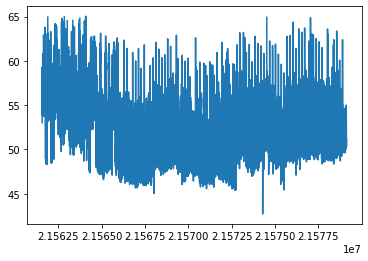

In [17]:
plt.plot(poc_electricity['meter_reading'])

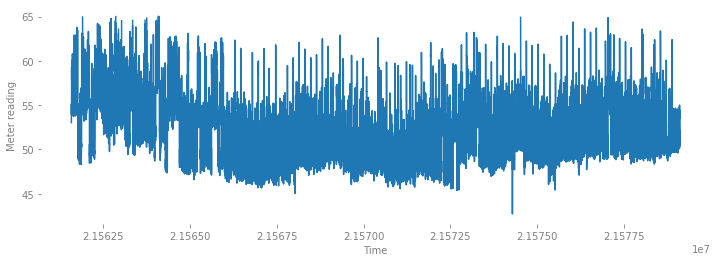

In [136]:
plt.figure(figsize=(12,4))

# use a gray background
ax = plt.axes()
ax.set_axisbelow(True)
ax.set_xlabel('Time')
ax.xaxis.label.set_color('gray')
ax.set_ylabel('Meter reading')
ax.yaxis.label.set_color('gray')


# draw solid white grid lines
plt.grid(color='w', linestyle='solid')

# hide axis spines
for spine in ax.spines.values():
    spine.set_visible(False)
    
# hide top and right ticks
ax.xaxis.tick_bottom()
ax.yaxis.tick_left()

# lighten ticks and labels
ax.tick_params(colors='gray', direction='out')
for tick in ax.get_xticklabels():
    tick.set_color('gray')
for tick in ax.get_yticklabels():
    tick.set_color('gray')

    
plt.plot(poc_electricity['meter_reading'])
plt.show()

In [19]:
timespan = poc_electricity['timestamp']
type(timespan)

pandas.core.series.Series

In [20]:
poc_electricity

,timestamp,building_id,meter_reading,meter
21561576,2016-01-01 00:00:00,Bear_utility_Sidney,53.0325,electricity_cleaned
21561577,2016-01-01 01:00:00,Bear_utility_Sidney,54.5325,electricity_cleaned
21561578,2016-01-01 02:00:00,Bear_utility_Sidney,55.1525,electricity_cleaned
21561579,2016-01-01 03:00:00,Bear_utility_Sidney,54.0900,electricity_cleaned
21561580,2016-01-01 04:00:00,Bear_utility_Sidney,53.9325,electricity_cleaned
...,...,...,...,...
21579115,2017-12-31 19:00:00,Bear_utility_Sidney,50.9025,electricity_cleaned
21579116,2017-12-31 20:00:00,Bear_utility_Sidney,52.1300,electricity_cleaned
21579117,2017-12-31 21:00:00,Bear_utility_Sidney,51.1325,electricity_cleaned
21579118,2017-12-31 22:00:00,Bear_utility_Sidney,51.1800,electricity_cleaned


In [21]:
train, test = train_test_split(poc_electricity, test_size=0.3)

# Idea dump 

# Preprocessing


### TODO
#### Come up with a strategy to handle nan values

Currently - just drop them

In [134]:
from scipy.fft import fft, fftfreq
from scipy.fft import rfft, rfftfreq
from scipy.fft import ifft, irfft

from sklearn.metrics import mean_squared_error

### Helper functions

In [41]:
# function to center data
center_function = lambda x: x - x.mean()

In [112]:
def generate_sine_wave(freq, sample_rate, duration, amplitude):
    x = np.linspace(0, duration, sample_rate * duration, endpoint=False)
    frequencies = x * freq
    # 2pi because np.sin takes radians
    y = np.sin((2 * np.pi) * frequencies) * amplitude
    return x, y

### Visual Inspection of the signal

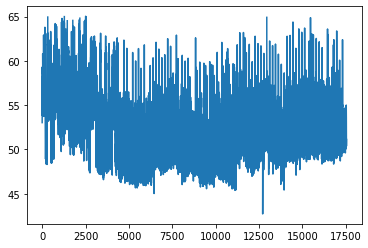

In [42]:
plt.plot(poc_electricity['meter_reading'].to_numpy())
plt.show()

### Data cleaning

In [45]:
# The raw metering data from the dataset 
raw_signal = poc_electricity['meter_reading'].to_numpy()

# Insepction of missing values
print("Amount of NaN values in the signal: ", np.isnan(raw_signal).sum())
print("Fraction of NaN values in the signal: ", np.isnan(raw_signal).sum()/ np.size(raw_signal))

Amount of NaN values in the signal:  73
Fraction of NaN values in the signal:  0.004160966712266302


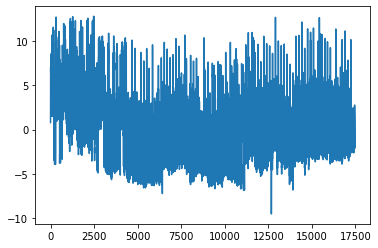

In [133]:
# Drop missing values as described in the provided notebook 10_Cleaned_dataset.ipyn of the repository
poc_electricity_no_nans = poc_electricity.dropna()
# Covnert the data into a numpy array and then center the data such that the values distributed around 0 
signal = center_function(poc_electricity_no_nans['meter_reading'].to_numpy())

# Plot the signal
plt.plot(signal)
plt.show()

### Specifiy variables for decomposition and reconstruction

In [62]:
# The amount of datapoints the signal contains
datapoints = np.size(signal)
# The minimal required sampling rate for this signal
sampling_rate = datapoints * 2

# Sampling Rate many steps between 0 and 1 with step size 1/sampling_rate. The amount of samples taken per step
#time = np.arange(0,1,1/sampling_rate)
# Datapoints per time step (Samplin_rate many)
#datapoints_per_timestep = np.size(time)
#frequency_domain = np.linspace(0,1,int(datapoints/2))


# Fast Fourier Decomposition


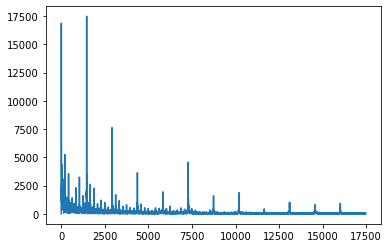

In [132]:
# Number of samples in normalized_tone

yf = rfft(signal)
xf = rfftfreq(input_points, 1 / sampling_rate)

plt.plot(xf, np.abs(yf))
plt.show()

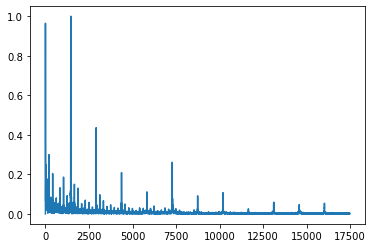

In [109]:
scale = 1/(input_points)
scaled_yf = scale * np.abs(yf)
plt.plot(xf, scaled_yf)
plt.show()

In [126]:
reconstructed_signal = irfft(yf)

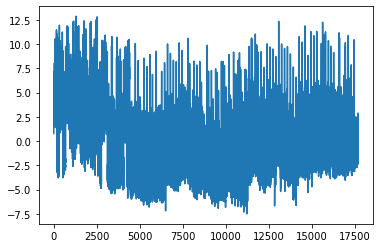

In [124]:
plt.plot(reconstructed_signal)
plt.show()

In [129]:
mean_squared_error(signal[0:-1], reconstructed_signal)

0.9333041132879647

In [ ]:
# Desired extended timespan
extended_length = 10

# Extend the spectrum
extended_spectrum = np.pad(yf, (0, extended_length - len(spectrum)), 'constant')

# Perform inverse Fourier transform
extended_signal = fft.irfft(extended_spectrum)

### TODO: 

- Train on train_data and test on test_data
- Try padding for 1 h, 1 day, 1 week
- Try different building types
- Organise into different methods
- 

In [116]:
np.size(signal)

17471

In [115]:
np.argwhere(scale * np.abs(yf) > 0.01)

array([[   1],
       [   2],
       [   3],
       ...,
       [8013],
       [8018],
       [8024]], dtype=int64)

In [114]:
extended_duration = input_points + 20
output_signal = np.zeros(extended_duration)
for index, freq in enumerate(np.argwhere(scaled_yf > 0.9)):
    print(index)
    f = freq[0]
    _, y = generate_sine_wave(f, sampling_rate, extended_duration, scaled_yf[f])
    output_signal += y

0


MemoryError: Unable to allocate 4.55 GiB for an array with shape (611170522,) and data type float64

In [ ]:
plt.plot(output_signal)
plt.show()

In [30]:
result_fft = rfft(center_function(signal))
fft_freq = 2/datapoints * abs(result_fft[0:np.size(frequency_domain)])
fft_frequencies = fft_freq

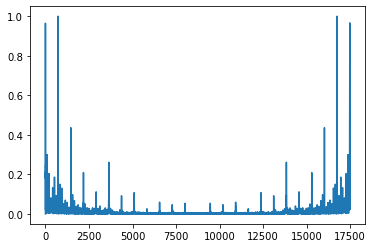

In [31]:
plt.plot(fft_frequencies)
plt.show()

In [32]:
N = sampling_rate * input_points
y_fft = fft(center_function(signal))
x_fft = fftfreq(input_points, 1/sampling_rate)


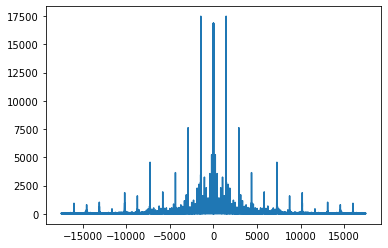

In [33]:
plt.plot(x_fft, np.abs(y_fft))
plt.show()

### Trying with rfft and rfftfreq

In [34]:
N = sampling_rate * input_points
y_rfft = rfft(center_function(signal))
x_rfft = rfftfreq(input_points, 1/sampling_rate)


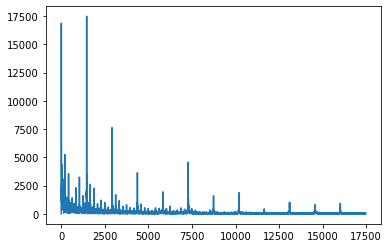

In [35]:
plt.plot(x_rfft, np.abs(y_rfft))
plt.show()

### Apply the inverse rfft

# Prediction of each signal into the future

# Reconstruction and Composition of the signal

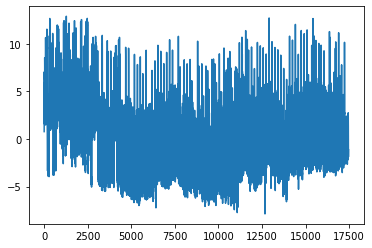

In [36]:
new_sig = irfft(y_rfft)

plt.plot(new_sig[:np.size(signal)])
plt.show()

In [37]:
np.size(signal)

17471

In [38]:
from sklearn.metrics import mean_squared_error

In [39]:
mean_squared_error(new_sig, signal)

ValueError: Found input variables with inconsistent numbers of samples: [17470, 17471]

In [ ]:
def generate_sine_wave(freq, sample_rate, duration, amplitude):
    x = np.linspace(0, duration, sample_rate * duration, endpoint=False)
    frequencies = x * freq
    # 2pi because np.sin takes radians
    y = amplitude * np.sin((2 * np.pi) * frequencies)
    
    return x, y

# Generate a 2 Hertz sine wave that lasts for 5 seconds
x, y = generate_sine_wave(2, SAMPLE_RATE, DURATION, AMPLITUDE)
plt.plot(x, y)
plt.show()

# TODO

Herausfinden was es mit der sampling_rate auf sich hat und wie sie gewählt werden muss für unsere Echtdaten

Anfangen und versuchen zu predicten

# Example from medium: 

https://medium.com/@khairulomar/deconstructing-time-series-using-fourier-transform-e52dd535a44e

#### Plot the data

In [ ]:
# Frequency and sampling rate
f = 10 # frequency
Fs = 100 # sampling rate
t = np.arange(0,1,1/Fs)
# Sine function
y = np.sin(2 * np.pi * f * t)
# Perform Fourier transform using scipy
from scipy import fftpack
y_fft = fftpack.fft(y)
# Plot data
n = np.size(t)
# fr is the x axis of the frequency domain. From 0 - 1 with datapoints/2 points in between multiplied by half of the sampling rate 
# equally many points between 0 and half of the sampling rate
fr = Fs/2 * np.linspace(0,1,int(n/2))
y_m = 2/n * abs(y_fft[0:np.size(fr)])
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15,5))
ax[0].plot(t, y)    # plot time series
ax[1].stem(fr, y_m) # plot freq domain